In [8]:
# --- 核心库 ---
import xarray as xr
from datetime import datetime, timezone, date
from pathlib import Path
import numpy as np
import io
import matplotlib.pyplot as plt

# --- 项目模块 ---
from chromasky_toolkit import config
from chromasky_toolkit.glow_index import GlowIndexCalculator
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image, clear_output
from typing import Literal

# --- 辅助函数 ---
def print_mask_friendly(mask: xr.DataArray, downsample_factor: int = 4):
    """以友好的字符形式打印布尔掩码，用于直观展示。"""
    if not isinstance(mask, xr.DataArray) or mask.dtype != bool:
        print("错误：输入必须是布尔型的 xarray.DataArray。")
        return
    resampled_mask = mask.coarsen(
        latitude=downsample_factor, longitude=downsample_factor, boundary="pad"
    ).max().astype(bool)
    lat_coords, lon_coords, mask_values = resampled_mask.latitude.values, resampled_mask.longitude.values, resampled_mask.values
    print(" " * 5, end="")
    for i in range(0, len(lon_coords), 5): print(f"{lon_coords[i]:<5.1f}", end="")
    print("\n")
    for i, lat in enumerate(lat_coords):
        print(f"{lat:>4.1f} ", end="")
        for val in mask_values[i, :]: print('■' if val else '·', end="")
        print("")
    print(f"\n图例: ■ = 计算区域 (True), · = 非计算区域 (False)")
    print(f"注意: 图像已按因子 {downsample_factor} 降采样以适应显示。")

print("✅ 环境设置完毕。")

✅ 环境设置完毕。


In [9]:
# ======================================================================
# --- 核心配置区：请在此处设置您的目标参数 ---
# ======================================================================

# 1. 设置您想分析的本地日期
TARGET_LOCAL_DATE_STR = "2025-05-25"

# 2. 设置您想分析的天文事件 ('sunrise' 或 'sunset')
EVENT_TYPE: Literal["sunrise", "sunset"] = "sunset"

# 3. (可选) 设置时间窗口的半径（分钟）
EVENT_WINDOW_MINUTES = 30

In [10]:
# --- 1. 根据配置初始化参数 ---
target_local_date = datetime.strptime(TARGET_LOCAL_DATE_STR, "%Y-%m-%d").date()
event_times_local = config.SUNRISE_EVENT_TIMES if EVENT_TYPE == 'sunrise' else config.SUNSET_EVENT_TIMES

print("\n" + "="*80)
print(f"===== 开始为 {target_local_date} 的 {EVENT_TYPE} 事件序列执行数据流水线 =====")
print(f"将要处理的本地时间点: {event_times_local}")
print("="*80)

# --- 2. 准备循环，一次性收集所有需要的数据 ---
generated_images = []         # 收集每张图的二进制数据
image_titles = []             # 收集每张图的标题
all_individual_masks = []     # 收集每个时间点独立的掩码
all_glow_index_arrays = []    # 收集每个时间点的指数网格数据

# --- 3. 遍历每个时间点，执行计算并收集结果 ---
for local_time_str in event_times_local:
    print("\n" + "-"*80)
    print(f"--- 正在处理本地时间: {local_time_str} ---")
    
    # a. 加载数据
    data_dir = config.PROCESSED_DATA_DIR / TARGET_LOCAL_DATE_STR
    time_str_for_path = local_time_str.replace(':', '')
    
    try:
        required_vars = ['hcc', 'mcc', 'lcc']
        data_arrays = {}
        for var in required_vars:
            filename = f"{var}_{time_str_for_path}.nc"
            path = data_dir / filename
            data_arrays[var] = xr.open_dataarray(path)
        weather_dataset = xr.Dataset(data_arrays)
        print(f"✅ 成功加载 {local_time_str} 的数据。")
        observation_time_utc = datetime.fromisoformat(weather_dataset.hcc.attrs['original_utc_time'])
    except Exception as e:
        print(f"❌ 加载数据时出错，跳过此时间点: {e}")
        continue

    # b. 计算与收集
    calculator = GlowIndexCalculator(weather_data=weather_dataset)
    active_region_mask = calculator.astro_service.create_event_mask(
        weather_dataset.latitude, weather_dataset.longitude, observation_time_utc, EVENT_TYPE, EVENT_WINDOW_MINUTES
    )
    glow_index_dataset = calculator.calculate_for_grid(
        utc_time=observation_time_utc,
        active_mask=active_region_mask
    )
    
    # c. 收集所有需要用于后续可视化的数据
    all_individual_masks.append(active_region_mask)
    all_glow_index_arrays.append(glow_index_dataset['final_score'])

    # d. 为独立图生成图像数据并收集
    map_title = (
        f"Glow Index ({EVENT_TYPE.capitalize()})\n"
        f"Local Time: {target_local_date} {local_time_str} ({config.LOCAL_TZ})\n"
        f"UTC Time: {observation_time_utc.strftime('%H:%M')}"
    )
    image_bytes = generate_map_from_grid(
        score_grid=glow_index_dataset['final_score'],
        title=map_title,
        active_region_mask=active_region_mask
    )
    
    if image_bytes:
        print(f"✅ 地图生成成功！")
        generated_images.append(image_bytes)
        image_titles.append(map_title)

# 清理中间过程的输出，为最终的可视化做准备
clear_output(wait=True)
print("✅ 所有时间点的计算和数据收集已完成。")

✅ 所有时间点的计算和数据收集已完成。



分时火烧云指数图 (4 张)



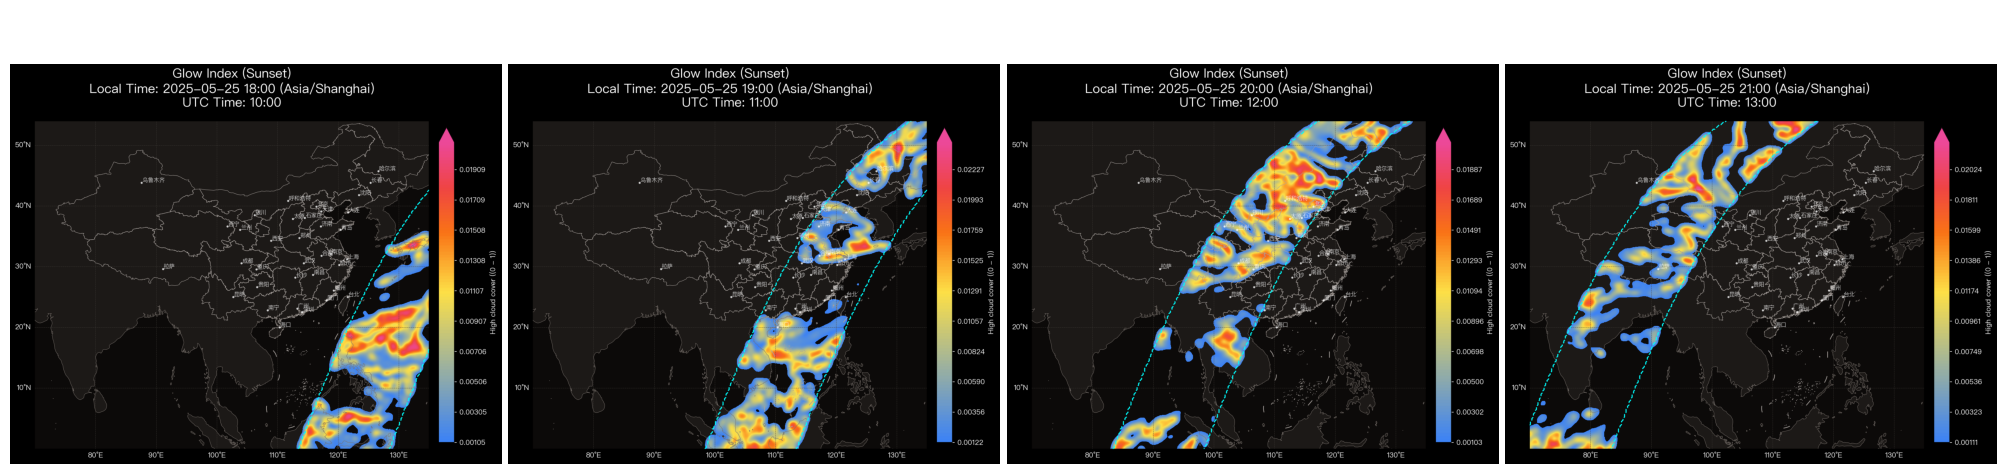

2025-08-07 23:00:46,879 - MapDrawer - INFO - --- [绘图] 开始生成地图: 综合最佳火烧云指数 (Sunset)
日期: 2025-05-25 | 时间段: 18:00 - 21:00 (Local Time) ---



综合最佳火烧云指数图



2025-08-07 23:00:47,355 - MapDrawer - INFO - 正在绘制活动区域掩码轮廓...
2025-08-07 23:00:51,019 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\src\outputs\maps\glow_index\glow_index_20250525_sunset_composite.png ---


✅ 综合最佳指数地图已成功生成并保存到: outputs\maps\glow_index\glow_index_20250525_sunset_composite.png


In [11]:
# --- 4. 统一可视化所有结果 ---

# a. 显示并排的独立时间点地图
if generated_images:
    print("\n" + "="*80)
    print(f"分时火烧云指数图 ({len(generated_images)} 张)")
    print("="*80 + "\n")
    
    num_images = len(generated_images)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5.5))
    if num_images == 1: axes = [axes]
    for i, (img_bytes, title) in enumerate(zip(generated_images, image_titles)):
        img = plt.imread(io.BytesIO(img_bytes), format='png')
        axes[i].imshow(img)
        axes[i].set_title(title, color='white', fontsize=10)
        axes[i].axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()
else:
    print("未能生成任何分时地图。")


# b. 生成并显示综合最佳指数图
if all_glow_index_arrays:
    print("\n" + "="*80)
    print("综合最佳火烧云指数图")
    print("="*80 + "\n")

    # 合并数据并计算最大值
    combined_glow_index = xr.concat(all_glow_index_arrays, dim='time').max(dim='time')
    combined_active_mask = xr.concat(all_individual_masks, dim='time').any(dim='time')

    # 准备标题和路径
    composite_map_title = (
        f"综合最佳火烧云指数 ({EVENT_TYPE.capitalize()})\n"
        f"日期: {target_local_date} | 时间段: {event_times_local[0]} - {event_times_local[-1]} (Local Time)"
    )
    output_dir = config.MAP_OUTPUTS_DIR / "glow_index"
    composite_map_output_path = output_dir / f"glow_index_{target_local_date.strftime('%Y%m%d')}_{EVENT_TYPE}_composite.png"
    
    # 生成图像
    composite_image_bytes = generate_map_from_grid(
        score_grid=combined_glow_index,
        title=composite_map_title,
        output_path=composite_map_output_path,
        active_region_mask=combined_active_mask
    )
    
    if composite_image_bytes:
        display(Image(data=composite_image_bytes, width=800))
        print(f"✅ 综合最佳指数地图已成功生成并保存到: {composite_map_output_path.relative_to(config.PROJECT_ROOT)}")
    else:
        print("\n❌ 综合最佳指数地图生成失败。")
else:
    print("\n没有任何指数数据被成功计算，无法生成综合地图。")